

---



---



#  **Brest Cancer Classification - Spark ML Pipeline**

---


---




## **Problem Statement**

1. **Objective:** Develop a machine learning model for precise breast cancer tumor classification.
2. **Problem:** Current diagnostic methods lack precision and may yield false results.
3. **Challenge 1 - Data Complexity:** Address diverse and complex patterns within diagnostic datasets.
4. **Challenge 2 - Feature Selection:** Identify and prioritize relevant features to enhance model interpretability.
5. **Challenge 3 - Imbalanced Data:** Mitigate bias arising from uneven distribution of malignant and benign samples.
6. **Challenge 4 - Interpretability:** Ensure model decisions are interpretable for healthcare professionals.
7. **Challenge 5 - Scalability:** Design a scalable model applicable to diverse datasets and healthcare settings.
8. **Impact:** Improve early detection, prognosis, and treatment planning for breast cancer, enhancing patient outcomes.

#  **Spark Install**

In [156]:
!pip3 -q install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Trilokesh').master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Trilokesh>

## Imports

In [157]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import  RandomForestClassifier, DecisionTreeClassifier,LogisticRegression
from pyspark.ml.regression import LinearRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

#  **Load Data**

In [158]:
!wget -O bcc.csv -q https://raw.githubusercontent.com/Trilokesh-Praxis-2023/Breast_Cancer_Classification/main/Breast%20Cancer/data.csv

In [159]:
#loading dataset into spark dataframe
df = spark.read.csv('bcc.csv', inferSchema=True,header=True)
df.show(15)

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+-----------+------

## DATA Information:
- ID number
- Diagnosis (M = malignant, B = benign)
- M is converted into 1, B is converted into 0
- Features that are computed for each cell nucleus:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

##  **Data Overview**

## Dropping insignificant  columns

In [160]:
df = df.drop('_c32')
df = df.drop('id')

In [161]:
df.show(5)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [162]:
# Show the columns of the DataFrame
columns_list = df.columns
# Display the column names
print(columns_list)

['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


#  **EDA**

In [163]:
# Display summary statistics for numerical columns
numerical_cols = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
df.select(columns_list).describe().show()

+-------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+
|summary|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_se|        concavity_se|   concave points_se|  

In [164]:
# Display summary statistics for categorical columns
categorical_cols = [ 'diagnosis']
df.select(categorical_cols).describe().show()

+-------+---------+
|summary|diagnosis|
+-------+---------+
|  count|      569|
|   mean|     NULL|
| stddev|     NULL|
|    min|        B|
|    max|        M|
+-------+---------+



In [165]:
# Visualize distributions of numerical columns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

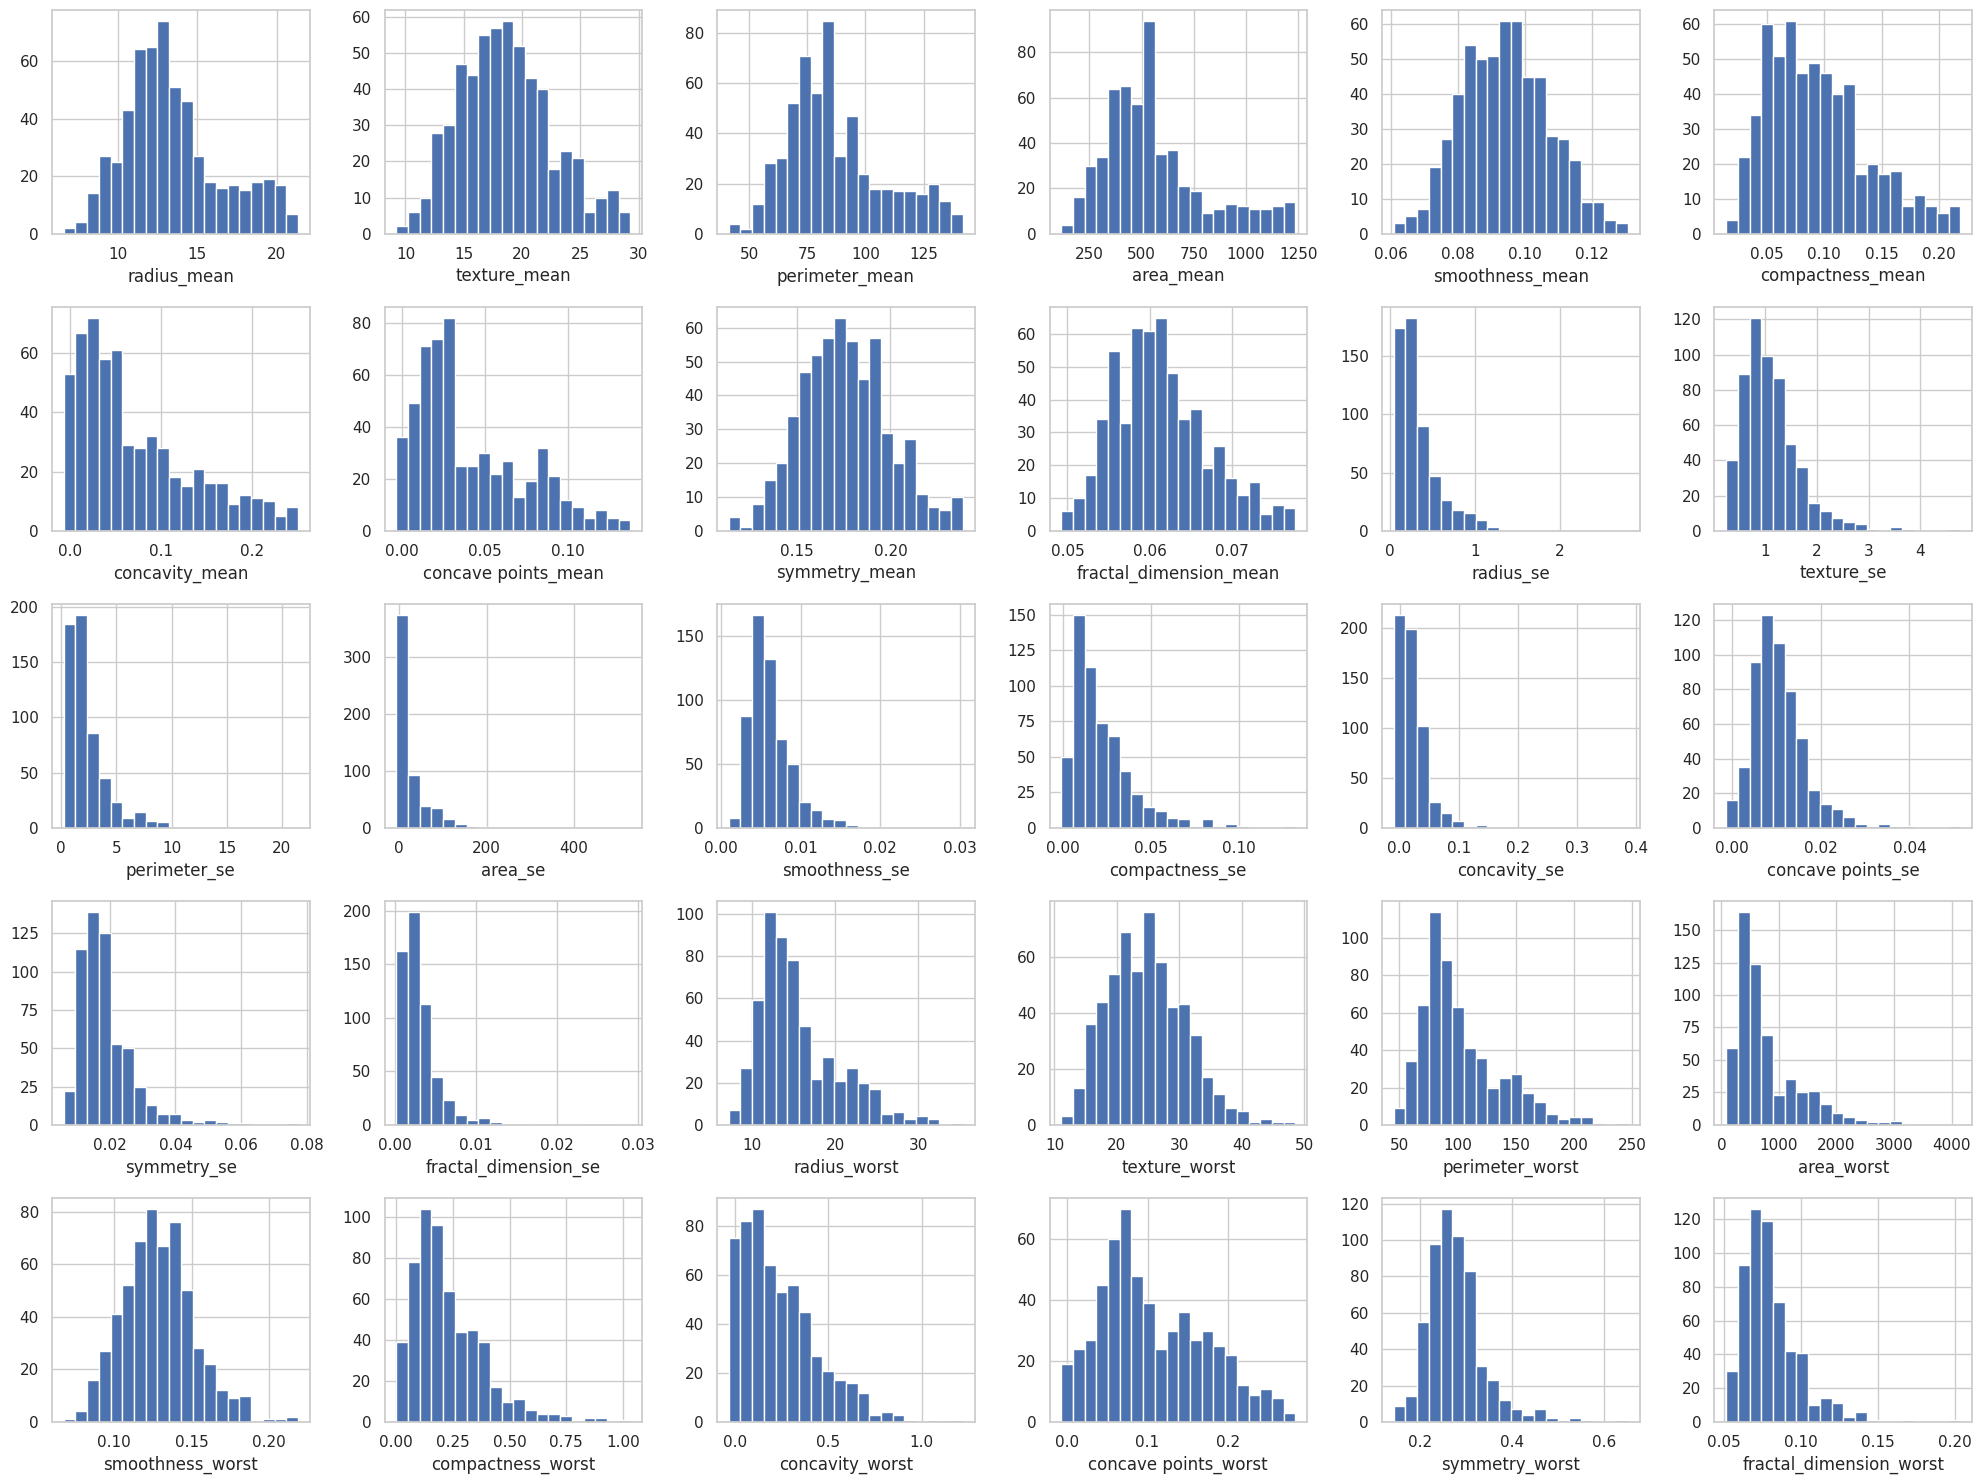

In [195]:
# Create a Spark session
spark = SparkSession.builder.appName("HistogramPlot").getOrCreate()
plt.figure(figsize=(20, 15))
plotnumber = 1
# Select numeric columns
numeric_columns = [column for column, data_type in df.dtypes if data_type == 'double']
for column in numeric_columns:
    if plotnumber <= 30:
        ax = plt.subplot(5, 6, plotnumber)
        # Calculate the histogram using PySpark
        histogram_data = df.select(column).rdd.flatMap(lambda x: x).histogram(20)
        bins, frequencies = histogram_data
        # Plot the histogram using Matplotlib
        ax.bar(bins[:-1], frequencies, width=(bins[1]-bins[0]))
        plt.xlabel(column)
    plotnumber += 1
plt.tight_layout()
plt.show()

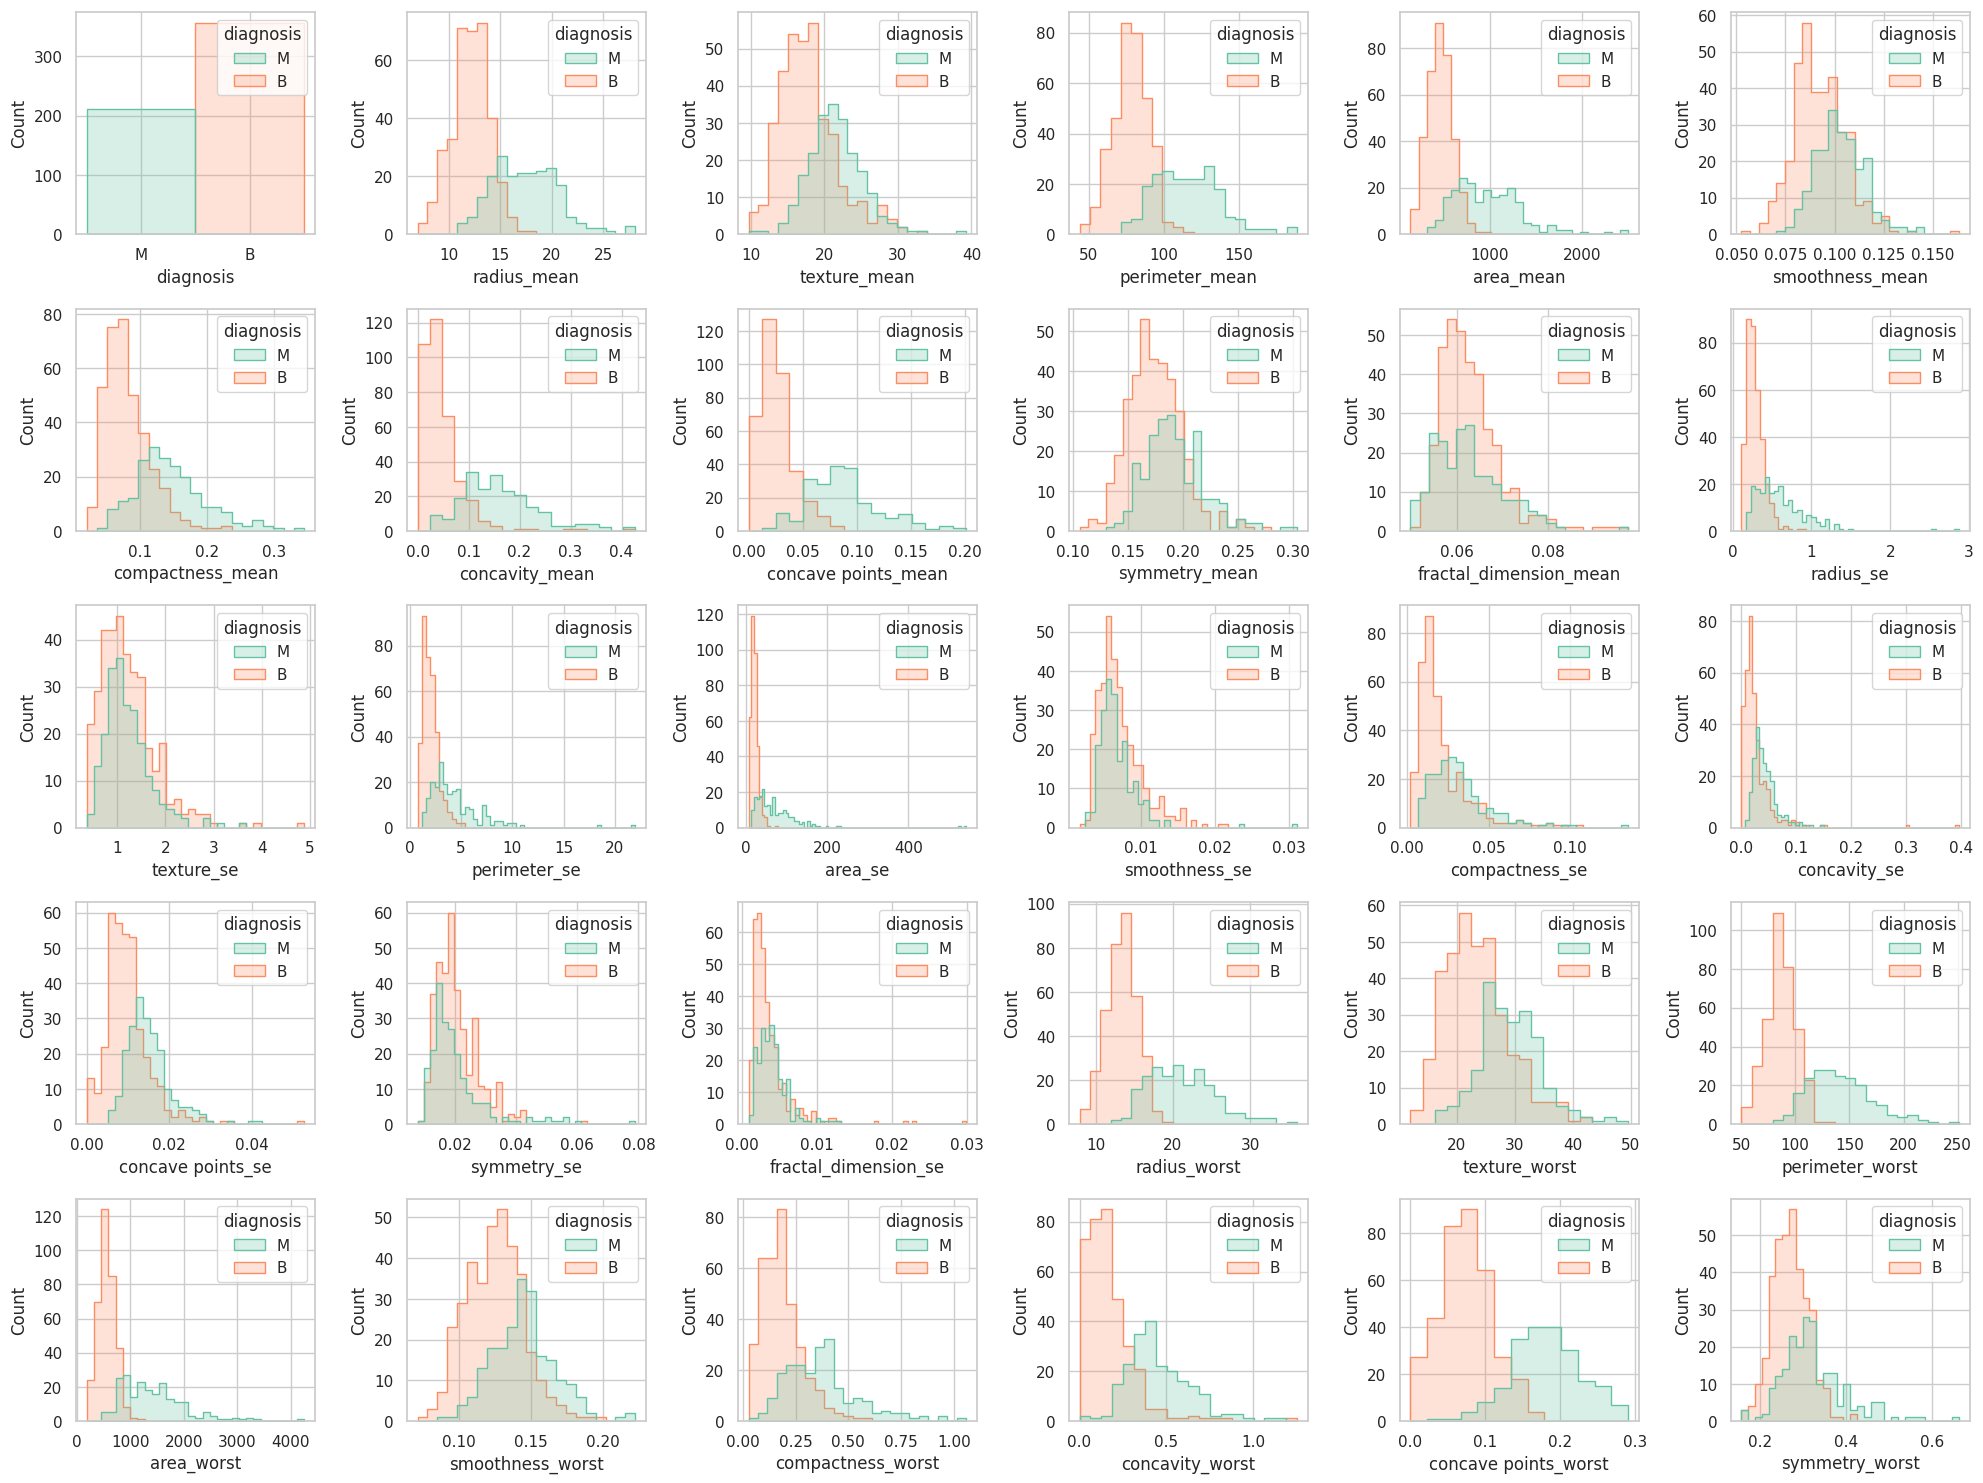

In [167]:
# Create a Spark session
spark = SparkSession.builder.appName("HistogramPlot").getOrCreate()
# Collect data to the local machine
data = df.select(col).toPandas()
plt.figure(figsize=(20, 15))
plotnumber = 1
for i in col:
    if plotnumber <= 30:
        ax = plt.subplot(5, 6, plotnumber)
        sns.histplot(data=data, x=i, hue=data['diagnosis'], multiple="layer", element="step", palette="Set2")
        plt.xlabel(i)
    plotnumber += 1
plt.tight_layout()
plt.show()

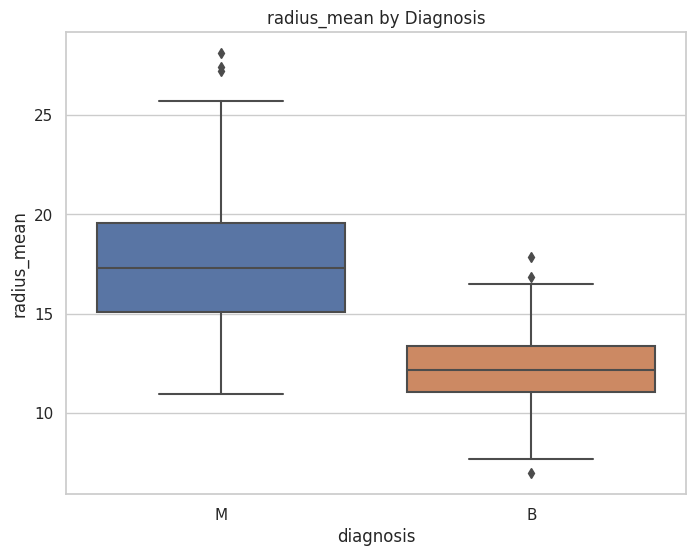

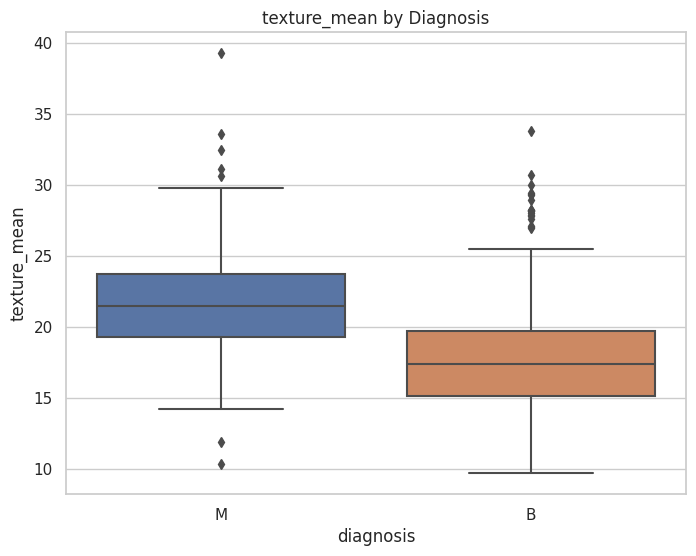

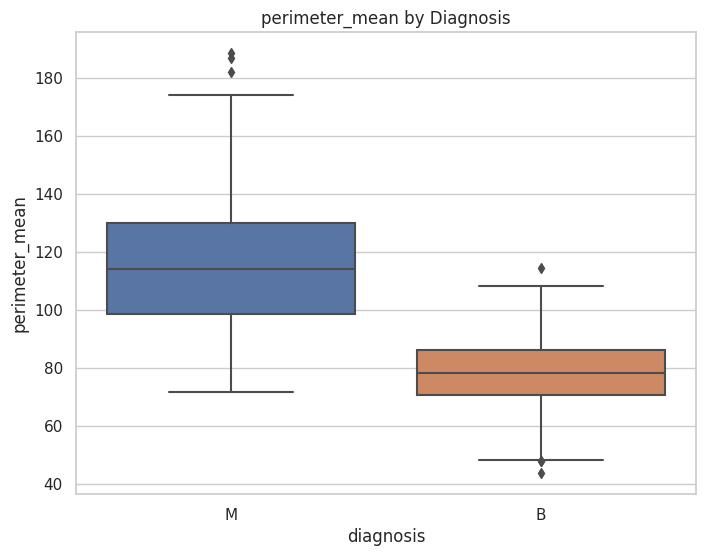

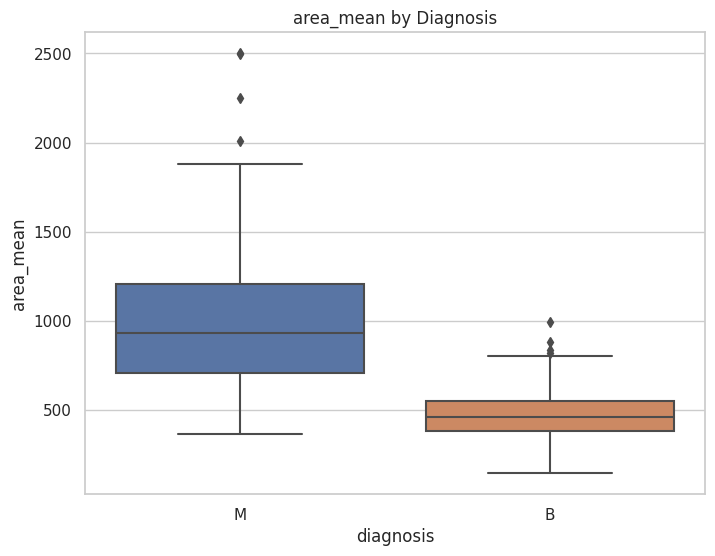

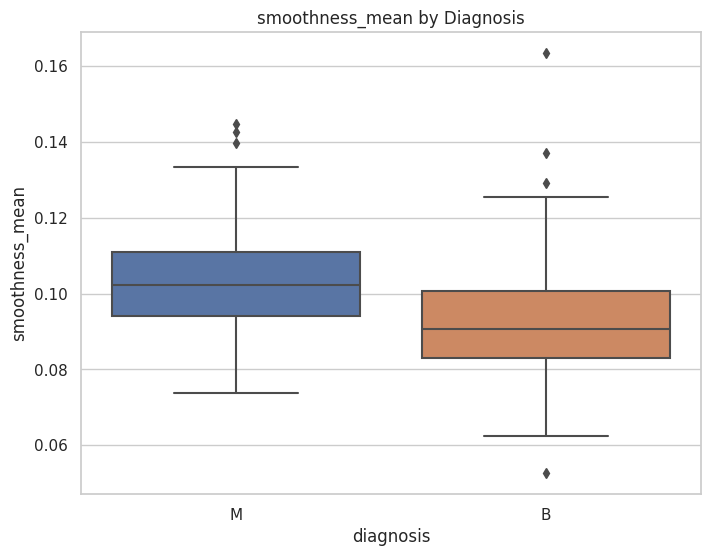

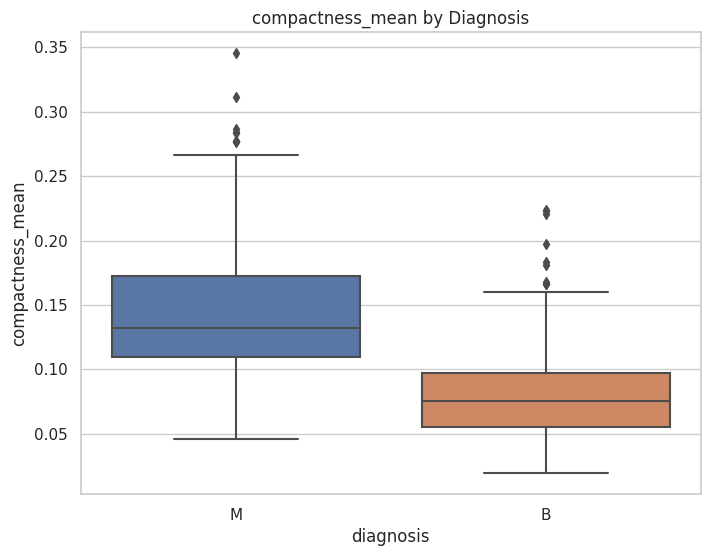

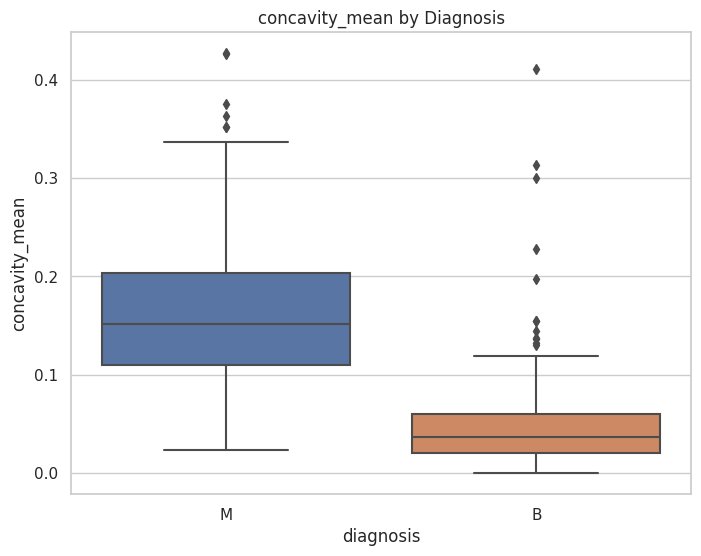

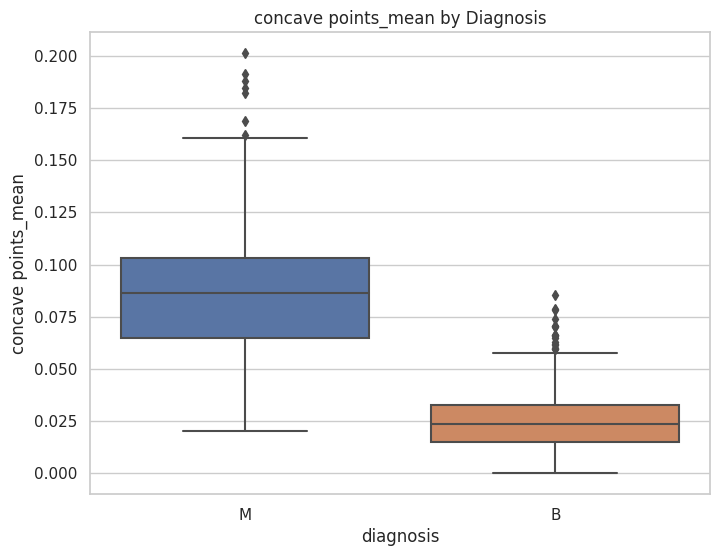

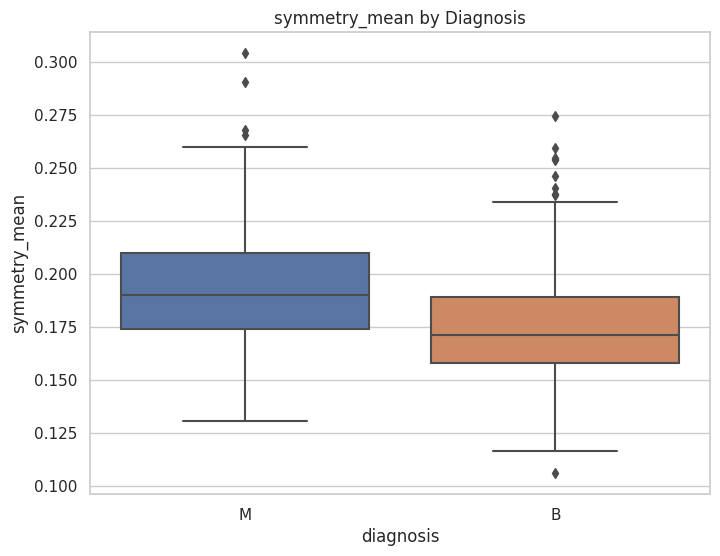

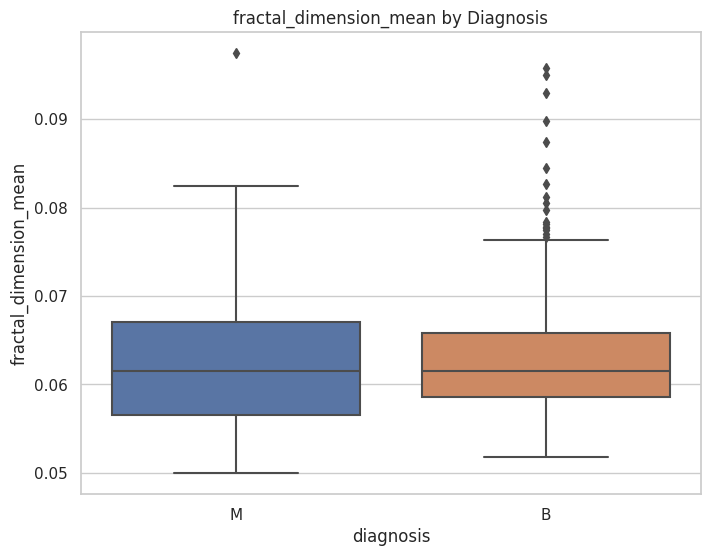

In [168]:
# Box plot for diagnosis vs. numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='diagnosis', y=col, data=df.toPandas())
    plt.title(f'{col} by Diagnosis')
    plt.show()

In [169]:
# Correlation matrix
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_assembled = vector_assembler.transform(df)
corr_matrix = Correlation.corr(df_assembled, "features").head()
print("Correlation Matrix:\n", corr_matrix[0])

Correlation Matrix:
 DenseMatrix([[ 1.        ,  0.32378189,  0.99785528,  0.98735717,  0.17058119,
               0.50612358,  0.67676355,  0.82252852,  0.14774124, -0.31163083],
             [ 0.32378189,  1.        ,  0.32953306,  0.3210857 , -0.02338852,
               0.23670222,  0.30241783,  0.29346405,  0.07140098, -0.07643718],
             [ 0.99785528,  0.32953306,  1.        ,  0.9865068 ,  0.20727816,
               0.55693621,  0.71613565,  0.85097704,  0.18302721, -0.26147691],
             [ 0.98735717,  0.3210857 ,  0.9865068 ,  1.        ,  0.17702838,
               0.49850168,  0.68598283,  0.82326887,  0.15129308, -0.28310981],
             [ 0.17058119, -0.02338852,  0.20727816,  0.17702838,  1.        ,
               0.65912322,  0.52198377,  0.55369517,  0.55777479,  0.584792  ],
             [ 0.50612358,  0.23670222,  0.55693621,  0.49850168,  0.65912322,
               1.        ,  0.88312067,  0.83113504,  0.60264105,  0.56536866],
             [ 0.67676355

<ipython-input-194-2386e340bfad>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.select(selected_columns).toPandas().corr()


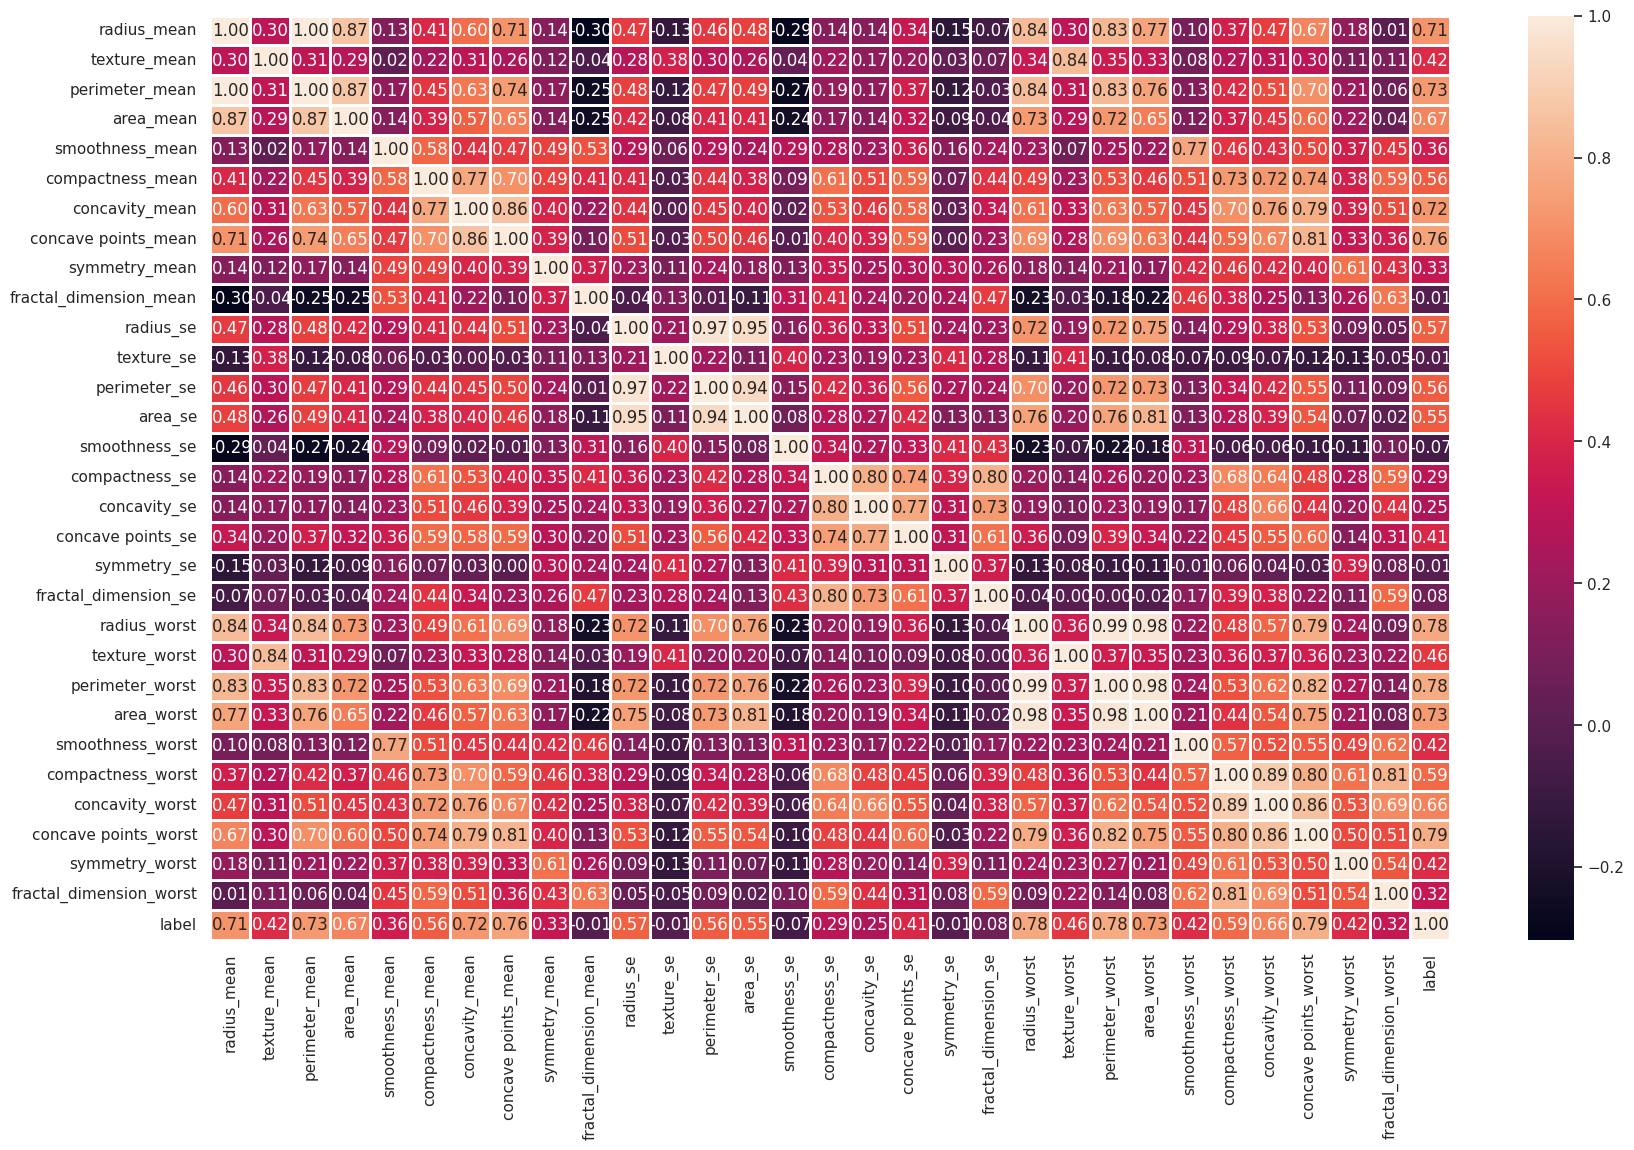

In [194]:
# Create a Spark session
spark = SparkSession.builder.appName("Heatmap").getOrCreate()
target_column = 'diagnosis'
# Select features and target variable
selected_columns = df.columns
selected_columns.remove(target_column)
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
# Convert the target variable to numeric using StringIndexer
indexer = StringIndexer(inputCol=target_column, outputCol="label")
# Calculate the correlation matrix
corr_matrix = df.select(selected_columns).toPandas().corr()
plt.figure(figsize=(20, 12))
# Plot the heatmap using Seaborn
sns.heatmap(corr_matrix,  linewidths=1, annot=True, fmt=".2f")
plt.show()

In [170]:
df.printSchema()

root
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)


In [171]:
#descriptive analysis
df.describe().show()

+-------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+
|summary|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_se|        concavity_se|   concave points_se|  

In [172]:
#diagnosis count
df.groupBy('diagnosis').count().show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
|        M|  212|
+---------+-----+



#  **EDA using Spark SQL**

In [173]:
# create DataFrame as a temporary view
df.createOrReplaceTempView("cancer_data")

In [174]:
# Perform SQL queries
query1 = "SELECT COUNT(*) as total_rows FROM cancer_data"
result1 = spark.sql(query1)
result1.show()

+----------+
|total_rows|
+----------+
|       569|
+----------+



In [175]:
query2 = "SELECT diagnosis, AVG(area_mean) as avg_area_mean FROM cancer_data GROUP BY diagnosis"
result2 = spark.sql(query2)
result2.show()

+---------+------------------+
|diagnosis|     avg_area_mean|
+---------+------------------+
|        B|462.79019607843145|
|        M| 978.3764150943397|
+---------+------------------+



In [176]:
# Check individual columns using group By function to understand the data in deeply.
df.groupBy('diagnosis').count().show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
|        M|  212|
+---------+-----+



In [177]:
query3 = "SELECT  diagnosis, radius_mean FROM cancer_data"
result3 = spark.sql(query3)
result3.show(5)

+---------+-----------+
|diagnosis|radius_mean|
+---------+-----------+
|        M|      17.99|
|        M|      20.57|
|        M|      19.69|
|        M|      11.42|
|        M|      20.29|
+---------+-----------+
only showing top 5 rows



In [178]:
query4 = "SELECT * FROM cancer_data WHERE diagnosis = 'M' AND area_mean > 800"
result4 = spark.sql(query4)
result4.show(5)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [179]:
query5 = "SELECT diagnosis, COUNT(*) as count_diagnosis FROM cancer_data GROUP BY diagnosis"
result5 = spark.sql(query5)
result5.show()

+---------+---------------+
|diagnosis|count_diagnosis|
+---------+---------------+
|        B|            357|
|        M|            212|
+---------+---------------+



In [180]:
query6 = "SELECT  diagnosis, area_mean FROM cancer_data ORDER BY area_mean DESC"
result6 = spark.sql(query6)
result6.show(5)

+---------+---------+
|diagnosis|area_mean|
+---------+---------+
|        M|   2501.0|
|        M|   2499.0|
|        M|   2250.0|
|        M|   2010.0|
|        M|   1878.0|
+---------+---------+
only showing top 5 rows



# Finding  Missing Values

In [181]:
#checking null values
df.toPandas().isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### There is no missing value in the dataset

#  **Preparing data for Modelling**

##  **Removing Outliers**

In [182]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
# Create a StringIndexer for the target variable
label_indexer = StringIndexer(inputCol='diagnosis', outputCol='label')
# Assemble features into a single vector column
feature_cols = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')


In [183]:
def replace_outliers_with_median(df, columns, multiplier=1.5):
    for column in columns:
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
        iqr = quantiles[1] - quantiles[0]
        lower_bound, upper_bound = quantiles[0] - multiplier * iqr, quantiles[1] + multiplier * iqr
        median_value = df.approxQuantile(column, [0.5], 0.01)[0]
        df = df.withColumn(column, F.when((df[column] < lower_bound) | (df[column] > upper_bound), median_value).otherwise(df[column]))
    return df

df = replace_outliers_with_median(df, feature_cols)

In [184]:
df.show(5)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

##  **Feature Selection and Vector Assembler**

## Lable Encoding With String Indexer

In [145]:
from pyspark.ml.feature import StringIndexer
# Create a StringIndexer for the 'diagnosis' column
label_indexer = StringIndexer(inputCol='diagnosis', outputCol='diagnosis_numeric')
df = label_indexer.fit(df).transform(df)
# Display the transformed DataFrame
df.show()

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|diagnosis_numeric|
+---------+-----------+-------

## Handling Imbalance Data

In [146]:
# Select features and target variable
selected_columns = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
# Separate features and target variable
X = df.select(*selected_columns)
y = df.select('diagnosis_numeric')
# Create a VectorAssembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
# Show the resulting DataFrames

## Splitting Data

In [147]:
train_data, test_data = df.randomSplit([0.6, 0.4], seed=0)

##  **Selecting top features**

In [148]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, ChiSqSelector
from pyspark.ml.classification import LogisticRegression

label_indexer = StringIndexer(inputCol='diagnosis_numeric', outputCol='label')
feature_cols = selected_columns
feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
selector = ChiSqSelector(numTopFeatures=5, featuresCol='features', outputCol='selected_features', labelCol='label')
classifier = LogisticRegression(featuresCol='selected_features', labelCol='label')
pipeline = Pipeline(stages=[label_indexer, feature_assembler, selector, classifier])
model = pipeline.fit(train_data)
selected_feature_names = [feature_cols[i] for i in model.stages[2].selectedFeatures]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'concave points_worst']


#  **DecisionTreeClassifier**

In [149]:
spark = SparkSession.builder.appName("DecisionTree").getOrCreate()
# Define features and target variable
feature_cols = selected_feature_names
target_col = 'diagnosis'
# Create a pipeline with StringIndexer, VectorAssembler, and Decision Tree
pipeline = Pipeline(stages=[
    StringIndexer(inputCol=target_col, outputCol='label'),
    VectorAssembler(inputCols=feature_cols, outputCol='features'),
    DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction')
])
# Fit the pipeline to the training data
model = pipeline.fit(train_data)
# Make predictions on the test data
predictions = model.transform(test_data)
# Evaluate the model
area_under_roc = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC').evaluate(predictions)
accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy').evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall').evaluate(predictions)
# Print results
print("Area under ROC: {:.2%}".format(area_under_roc))
print("Accuracy: {:.2%}".format(accuracy))
print("Recall: {:.2%}".format(recall))

Area under ROC: 93.67%
Accuracy: 92.24%
Recall: 92.24%


#  **Logistic Regression**

In [150]:
spark = SparkSession.builder.appName("LogisticRegression").getOrCreate()
# Define features and target variable
feature_cols = selected_feature_names
target_col = 'diagnosis'
# Create a pipeline with StringIndexer, VectorAssembler, and LogisticRegression
pipeline = Pipeline(stages=[
    StringIndexer(inputCol=target_col, outputCol='label'),
    VectorAssembler(inputCols=feature_cols, outputCol='features'),
    LogisticRegression(featuresCol='features', labelCol='label')
])
model = pipeline.fit(train_data)
# Make predictions on the test data
predictions = model.transform(test_data)
# Evaluate the model
area_under_roc = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC').evaluate(predictions)
accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy').evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall').evaluate(predictions)
# Print results
print("Area under ROC: {:.2%}".format(area_under_roc))
print("Accuracy: {:.2%}".format(accuracy))
print("Recall: {:.2%}".format(recall))

Area under ROC: 98.12%
Accuracy: 94.83%
Recall: 94.83%


#   **Random Forest**

In [151]:
from pyspark.ml.classification import RandomForestClassifier
spark = SparkSession.builder.appName("RandomForest").getOrCreate()
# Define features and target variable
feature_cols = selected_feature_names
target_col = 'diagnosis'
# Create a pipeline with StringIndexer, VectorAssembler, and RandomForestClassifier
pipeline = Pipeline(stages=[
    StringIndexer(inputCol=target_col, outputCol='label'),
    VectorAssembler(inputCols=feature_cols, outputCol='features'),
    RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100)
])
model = pipeline.fit(train_data)
# Make predictions on the test data
predictions = model.transform(test_data)
# Evaluate the model
area_under_roc = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC').evaluate(predictions)
accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy').evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall').evaluate(predictions)
# Print results
print("Area under ROC: {:.2%}".format(area_under_roc))
print("Accuracy: {:.2%}".format(accuracy))
print("Recall: {:.2%}".format(recall))

Area under ROC: 98.27%
Accuracy: 93.53%
Recall: 93.53%


# Logistic Regression gives the best result

 - Logistic Regression excels for binary classification due to simplicity, efficiency, and interpretability. It's robust with linearly separable data, handles feature importance well, and mitigates overfitting through regularization techniques.